Dataset 1 loaded in 21.02 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)


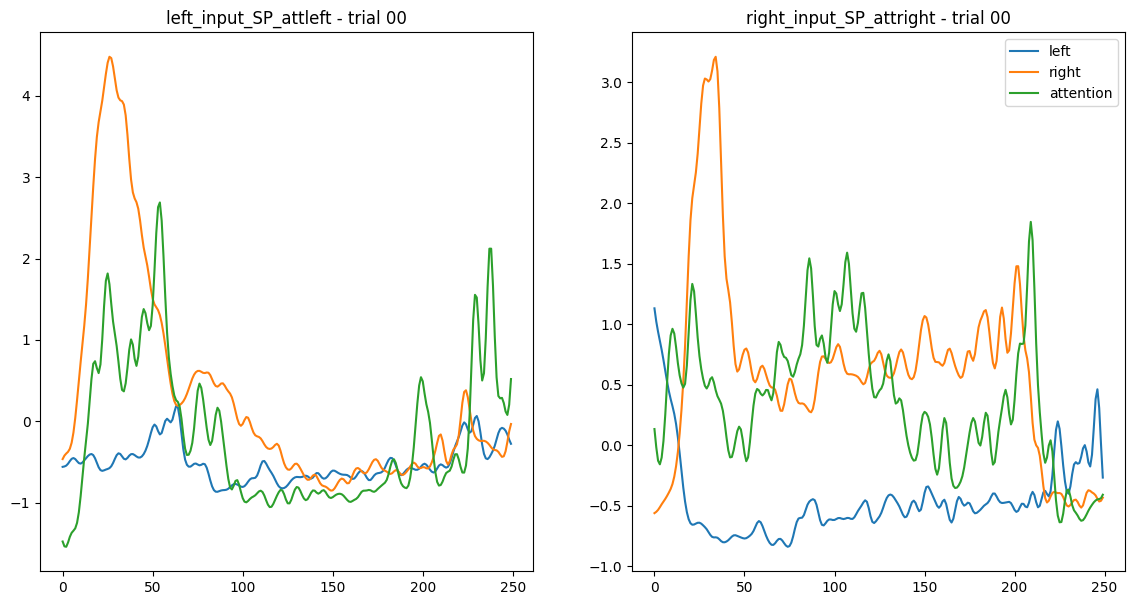

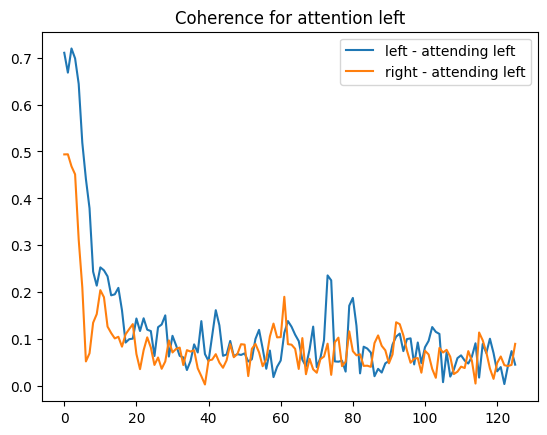

Dataset 1 complete in 36.72275519371033
Dataset 2 loaded in 12.22 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0, 1, 2]),)


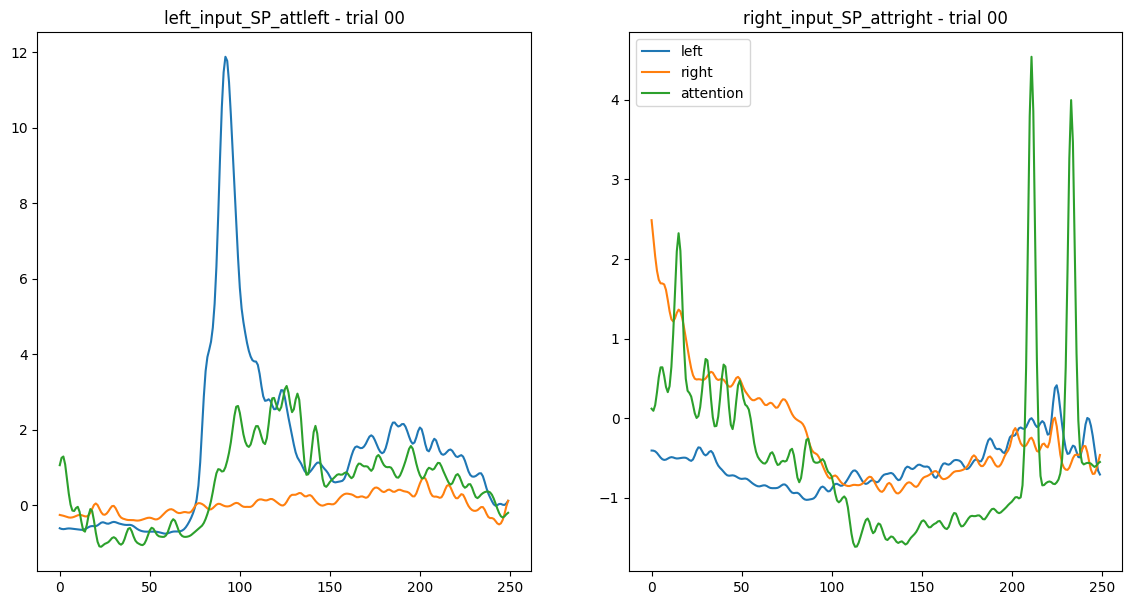

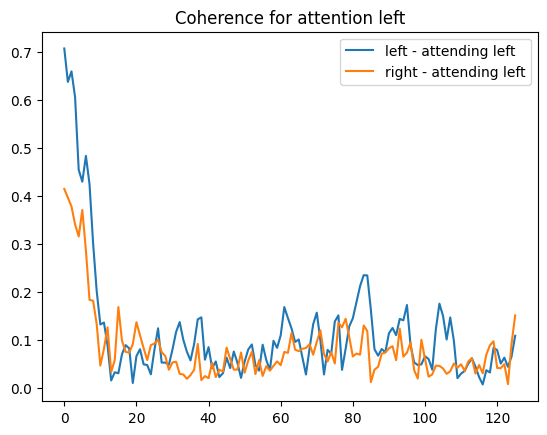

Dataset 2 complete in 26.13293981552124
Dataset 4 loaded in 13.22 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0]),)


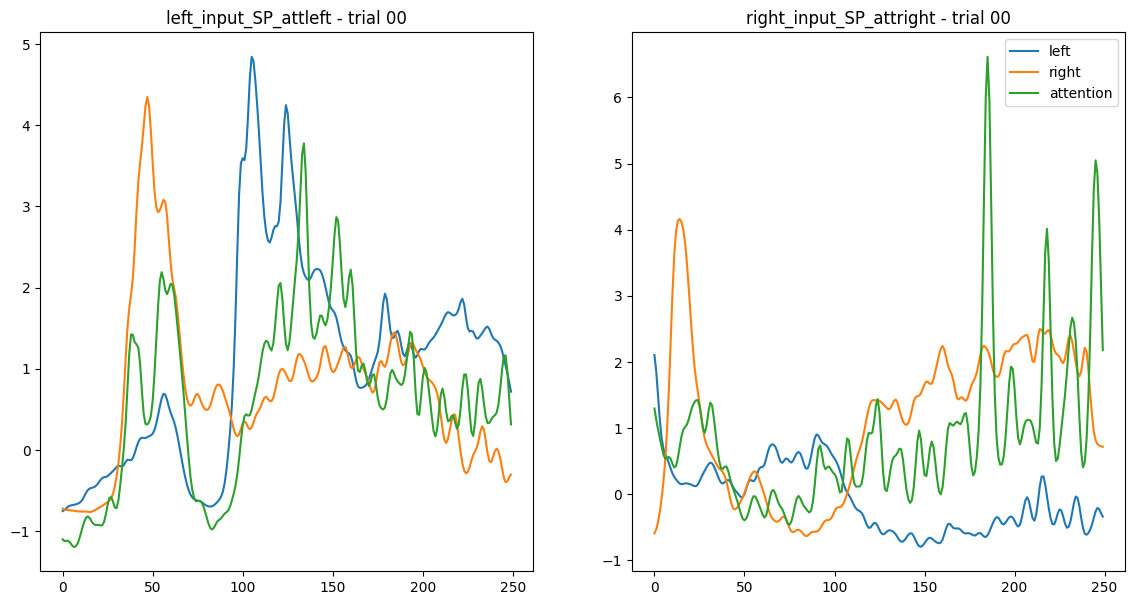

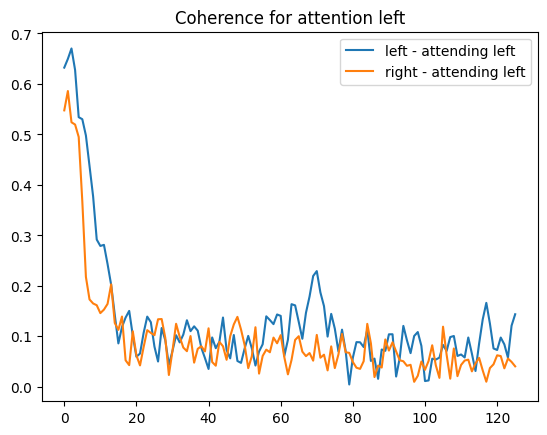

Dataset 4 complete in 27.29136896133423
Dataset 8 loaded in 26.22 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0, 1]),)


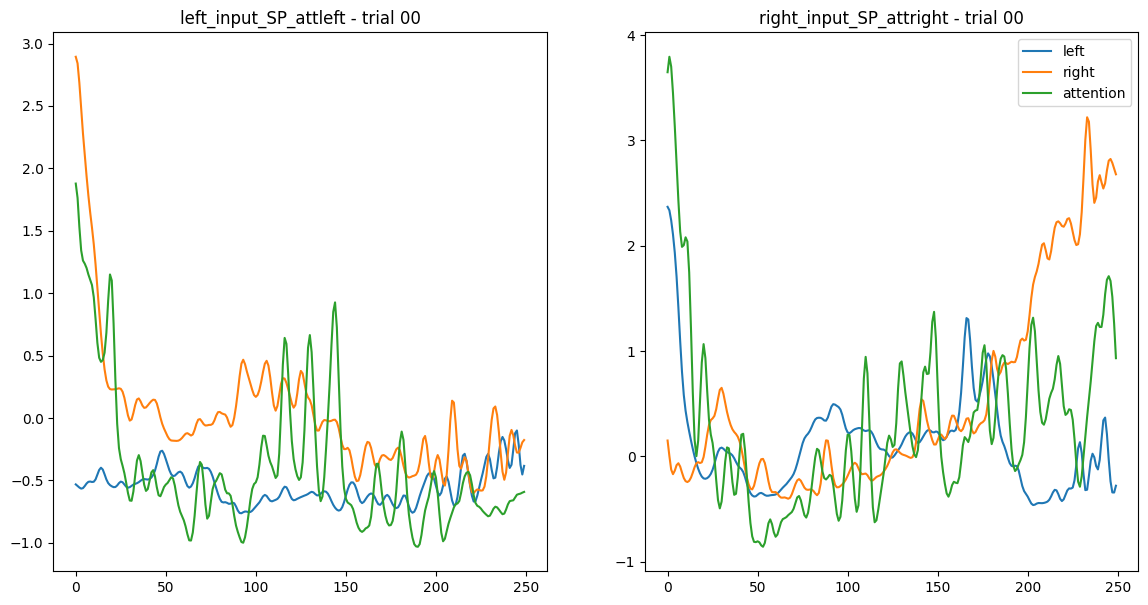

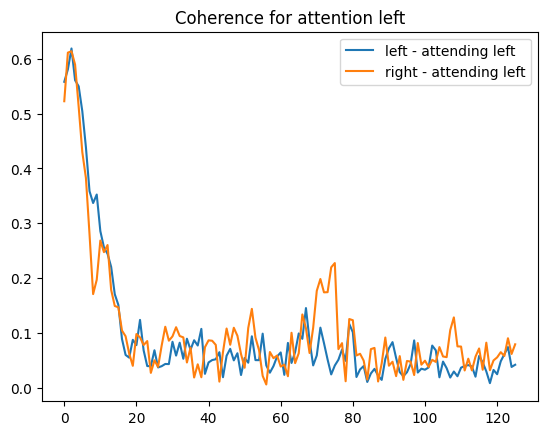

Dataset 8 complete in 52.6794548034668
Dataset 14 loaded in 16.57 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0, 1, 2]),)


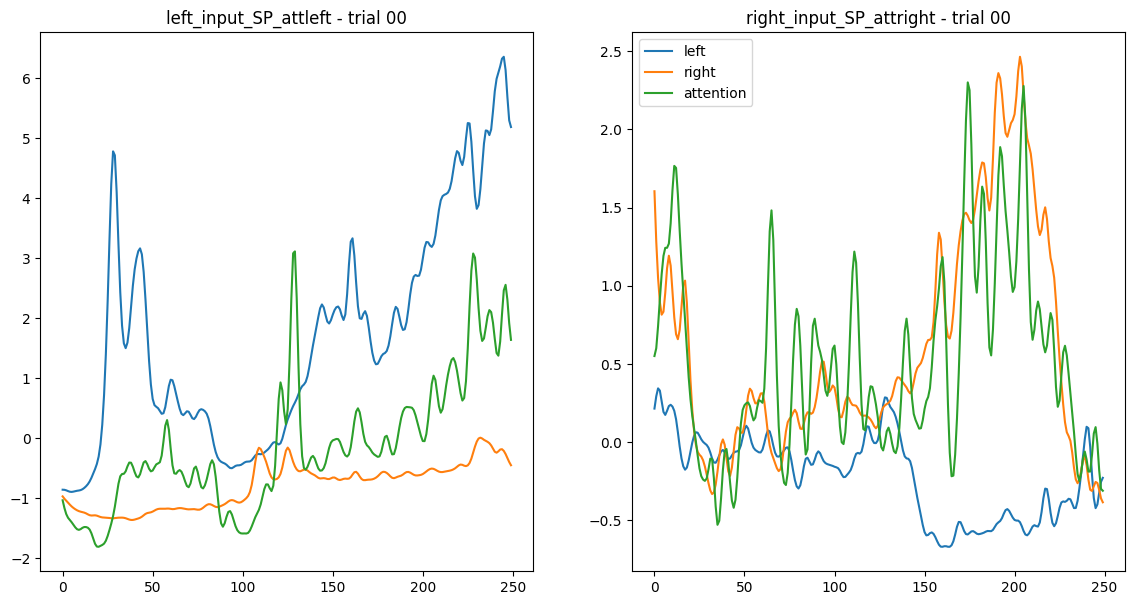

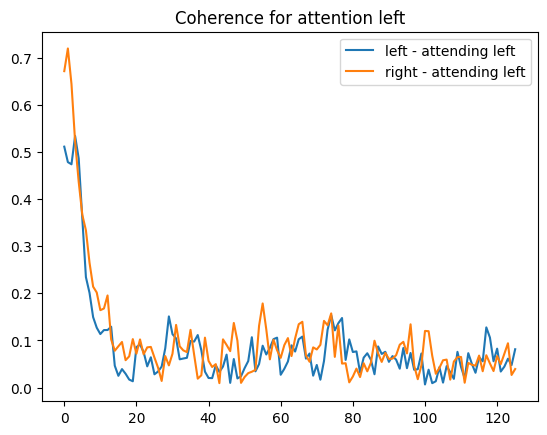

Dataset 14 complete in 29.594630479812622
Dataset 15 loaded in 17.03 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0]),)


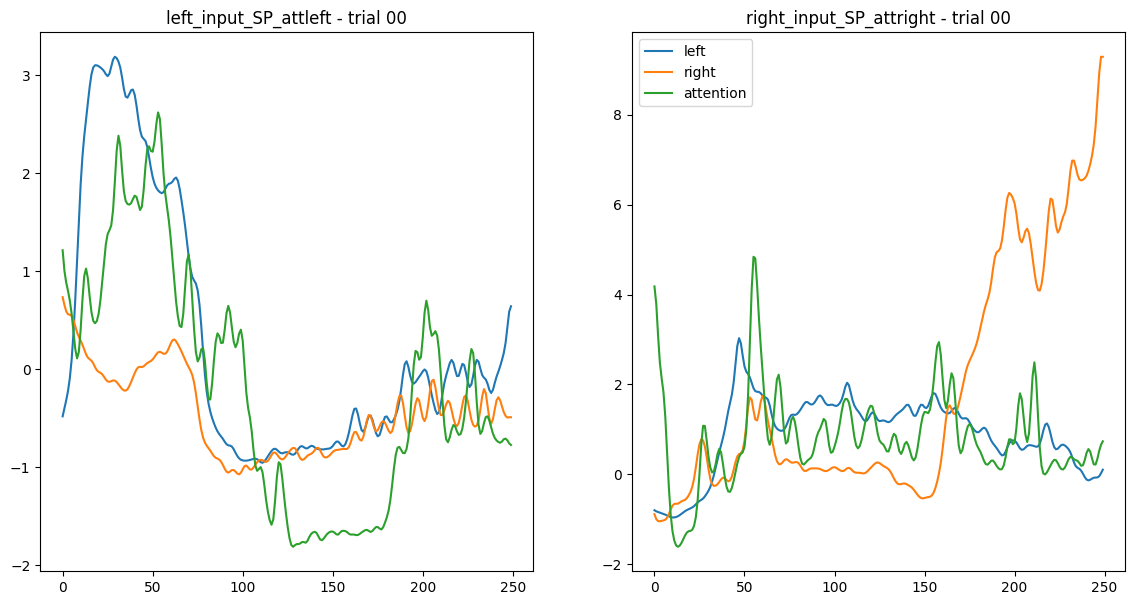

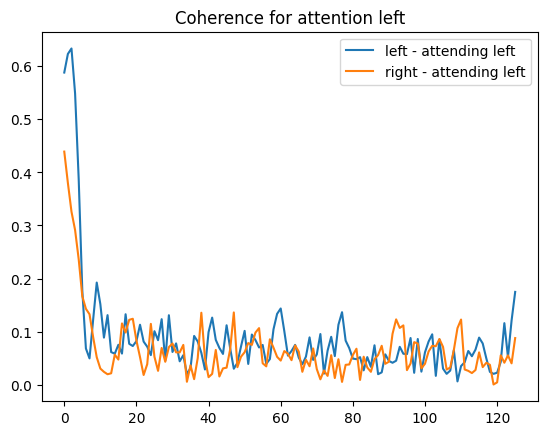

Dataset 15 complete in 59.434911251068115
Dataset 20 loaded in 36.47 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([0]),)


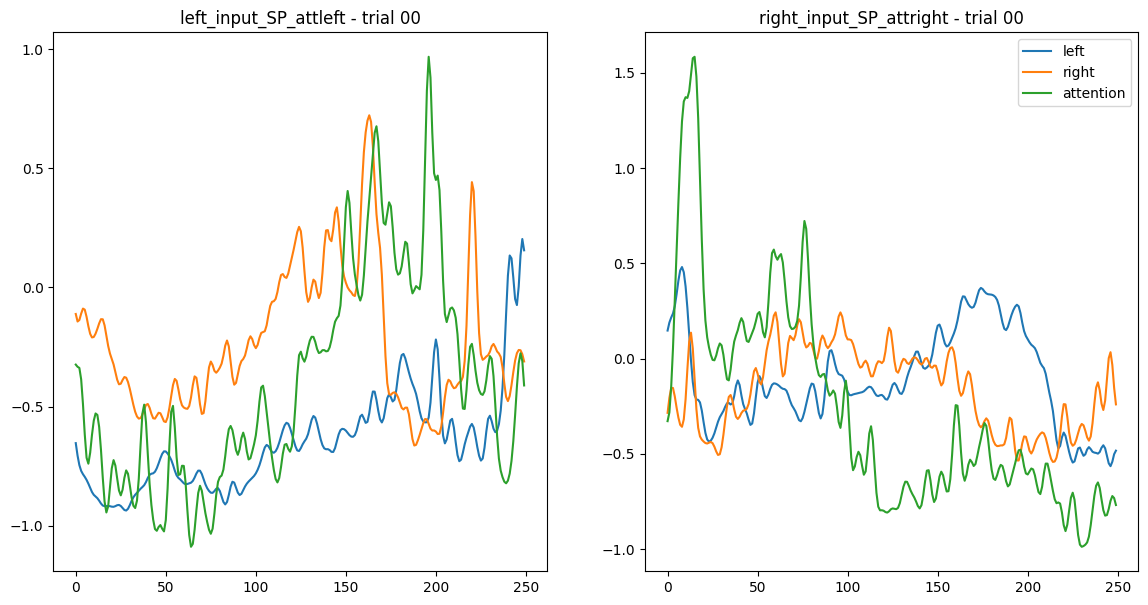

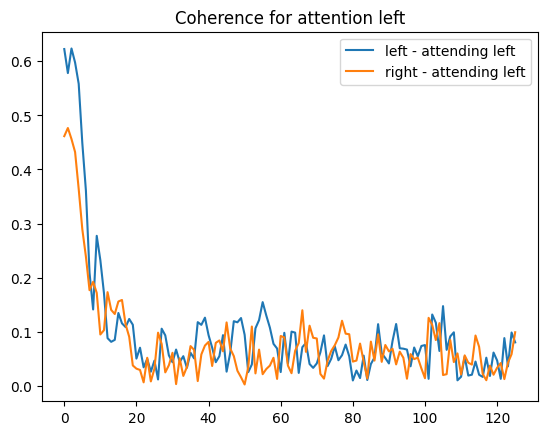

Dataset 20 complete in 72.1420156955719
Dataset 23 loaded in 19.40 seconds
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)
non constant column at  (array([], dtype=int64),)


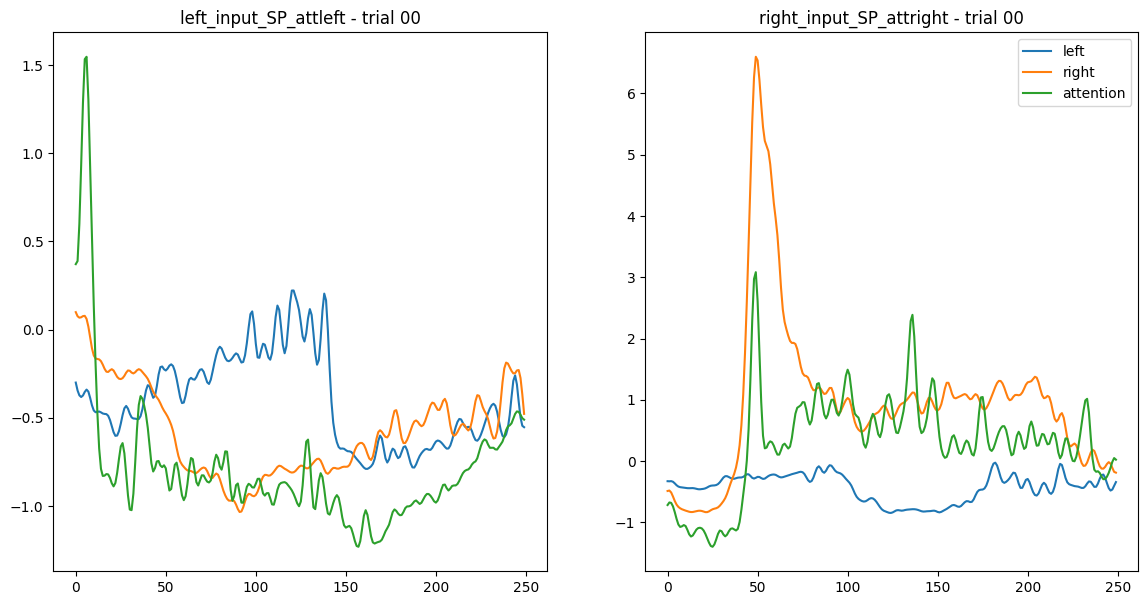

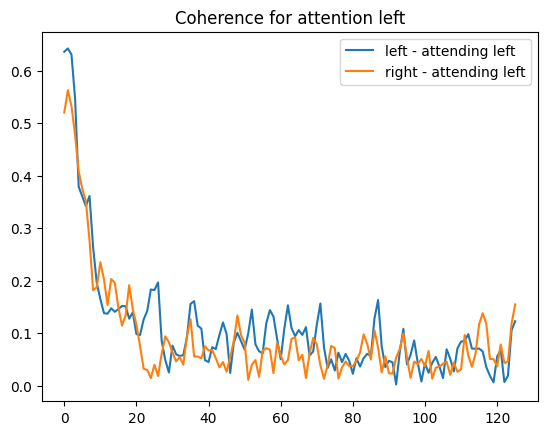

Dataset 23 complete in 46.70095777511597
total time elapsed = 350.7089834213257
{'dataset_1': {'delta': {'left_attleft': np.float64(1.3786920507752987), 'right_attleft': np.float64(0.9877291697208849), 'left_attright': np.float64(0.9814094271789826), 'right_attright': np.float64(1.2908193700872224)}, 'theta': {'left_attleft': np.float64(1.4182119210438549), 'right_attleft': np.float64(0.91965046458645), 'left_attright': np.float64(0.9337674512347822), 'right_attright': np.float64(0.9953749322717497)}, 'alpha': {'left_attleft': np.float64(2.1065051651804083), 'right_attleft': np.float64(0.8033157958335201), 'left_attright': np.float64(1.4179164284743297), 'right_attright': np.float64(1.4669057074913572)}, 'beta': {'left_attleft': np.float64(3.3232771229508926), 'right_attleft': np.float64(2.0323609241657756), 'left_attright': np.float64(3.2047231733076718), 'right_attright': np.float64(1.5483641974090507)}, 'gamma': {'left_attleft': np.float64(5.123867687231204), 'right_attleft': np.flo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps

coherence_path = r"C:\Users\joshu\nice\testcodepearsoncoherence"
sys.path.append(coherence_path)
import coherence  
from coherence import field_field_coherence


from scipy.ndimage import gaussian_filter1d
def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 
sigma = 2

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

# def preprocess(data):
#     data = detrend(data, axis=0)
#     epsilon = 1e-9
#     data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
#     return data

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds > 1e-6
    if len(non_constant_cols) != 0:
        print('non constant column at ', np.where(non_constant_cols == False))
                

    constant_cols = stds < 1e-6

    z = np.zeros_like(data[:, :])
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)
    z[:, constant_cols] = np.mean(data[:, constant_cols], axis = 0)

    #unsure what to replace lost values with, for now replacing with 0

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

dt = 0.002
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']   #for coherence I have looked at the mean valuee for these bands
freq_ranges = [(0, 4), (4, 8), (8, 13), (13, 30), (30, 80)]  # Actual frequency ranges

def coherence_auc(data, condition):
   for band, (fmin, fmax) in zip(bands, freq_ranges):
        band_idx = (freq >= fmin) & (freq < fmax)
        all_idx = freq < 80

        coherence_results[f'dataset_{file_number}'][band][f'{condition}'] = simps(data[band_idx], freq[band_idx])
        Norm[f'dataset_{file_number}'][band][f'{condition}']  = simps(data[all_idx], freq[all_idx])
      

structure = {f'dataset_{file_number}': {f'{band}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for band in bands} for file_number in file_numbers} 

coherence_results = copy.deepcopy(structure)
Norm = copy.deepcopy(structure)

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
    # left_input_SP (2032, 500, 160)
    # right_input_SP (2032, 500, 160)
    # attention_SP (2032, 500, 80)

    ## with the LPF signals, was safe to just zscore and detrend
    #here have to make the signals and then process.
    #will just pick out the relavant trials for now

    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    sigma = 2

    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80

            
    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention


    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)

    #preprocess here now that we have traces of all of the relavant trials
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)

    #splitting left and right
    left_input_SP_attleft = left_input_SP[left_indices, 100:350]
    right_input_SP_attleft = right_input_SP[left_indices, 100:350]
    attention_SP_attleft = attention_SP[left_indices, 100:350]

    left_input_SP_attright = left_input_SP[right_indices, 100:350]
    right_input_SP_attright = right_input_SP[right_indices, 100:350]
    attention_SP_attright = attention_SP[right_indices, 100:350]

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].plot(np.mean(left_input_SP_attleft[:, :], axis = 0), label = 'left')
    ax[0].plot(np.mean(right_input_SP_attleft[:, :], axis = 0), label = 'right')
    ax[0].plot(np.mean(attention_SP_attleft, axis = 0), label = 'attention')
    ax[0].set_title('left_input_SP_attleft - mean across trials')
    ax[1].plot(np.mean(left_input_SP_attright[:, :], axis = 0), label = 'left')
    ax[1].plot(np.mean(right_input_SP_attright[:, :], axis = 0), label = 'right')
    ax[1].plot(np.mean(attention_SP_attright, axis = 0), label = 'attention')
    ax[1].set_title('right_input_SP_attright mean across trials')
    plt.legend()
    plt.show()

    plt.plot(np.mean(left_input_SP_attleft[:, :], axis = 0), label = 'left input - attleft')
    plt.plot(-1 * np.mean(left_input_SP_attright[:, :], axis = 0), label = 'negative of left input - attright')
    plt.title('mean of left attleft and negative of left attright')
    plt.legend()
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].plot(left_input_SP_attleft[0, :], label = 'left input - attleft')
    ax[0].plot(right_input_SP_attleft[0, :], label = 'right input - attleft')
    ax[0].plot(attention_SP_attleft[0, :], label = 'attention - attleft')
    ax[0].set_title('trial 0 attleft data')
    ax[1].plot(left_input_SP_attright[0, :], label = 'left input - attright')
    ax[1].plot(right_input_SP_attright[0, :], label = 'right input - attright')
    ax[1].plot(attention_SP_attright[0, :], label = 'attention - attright')
    ax[1].set_title('trial 0 attright data')
    plt.legend()
    plt.show()

    #----- computing coherence ----------------
    left_attleft_coherence, freq = field_field_coherence(
        left_input_SP_attleft, attention_SP_attleft, dt)
    right_attleft_coherence, freq = field_field_coherence(
        right_input_SP_attleft, attention_SP_attleft, dt)
    left_attright_coherence, freq = field_field_coherence(
        left_input_SP_attright, attention_SP_attright, dt)
    right_attright_coherence, freq = field_field_coherence(
        right_input_SP_attright, attention_SP_attright, dt)

    plt.plot(left_attleft_coherence, label = 'left - attending left')
    plt.plot(right_attleft_coherence, label = 'right - attending left')
    plt.legend()
    plt.title('Coherence for attention left')
    plt.show()
      
    coh_structure = {f'{band}': [] for band in bands}
    left_attleft_coherence_bands = copy.deepcopy(coh_structure)
    right_attleft_coherence_bands = copy.deepcopy(coh_structure)
    left_attright_coherence_bands = copy.deepcopy(coh_structure)
    right_attright_coherence_bands = copy.deepcopy(coh_structure)
        
    coherence_auc(left_attleft_coherence, 'left_attleft')
    coherence_auc(right_attleft_coherence, 'right_attleft')
    coherence_auc(left_attright_coherence, 'left_attright')
    coherence_auc(right_attright_coherence, 'right_attright')

    del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)
print(coherence_results)


{'left_attleft': np.float64(1.3786920507752987), 'right_attleft': np.float64(0.9877291697208849), 'left_attright': np.float64(0.9814094271789826), 'right_attright': np.float64(1.2908193700872224)}
{'left_attleft': np.float64(1.3463628319637553), 'right_attleft': np.float64(0.8125188881254316), 'left_attright': np.float64(1.2048106652253963), 'right_attright': np.float64(1.233096383250571)}
{'left_attleft': np.float64(1.2818455998860139), 'right_attleft': np.float64(1.1334272026794916), 'left_attright': np.float64(1.1620939240999593), 'right_attright': np.float64(1.109266866380473)}
{'left_attleft': np.float64(1.1385271402841504), 'right_attleft': np.float64(1.1337137885768835), 'left_attright': np.float64(0.9670023629343133), 'right_attright': np.float64(1.2319517489214709)}
{'left_attleft': np.float64(0.9897520086953027), 'right_attleft': np.float64(1.391126251863328), 'left_attright': np.float64(0.931772476841724), 'right_attright': np.float64(1.4596777445157028)}
{'left_attleft': np

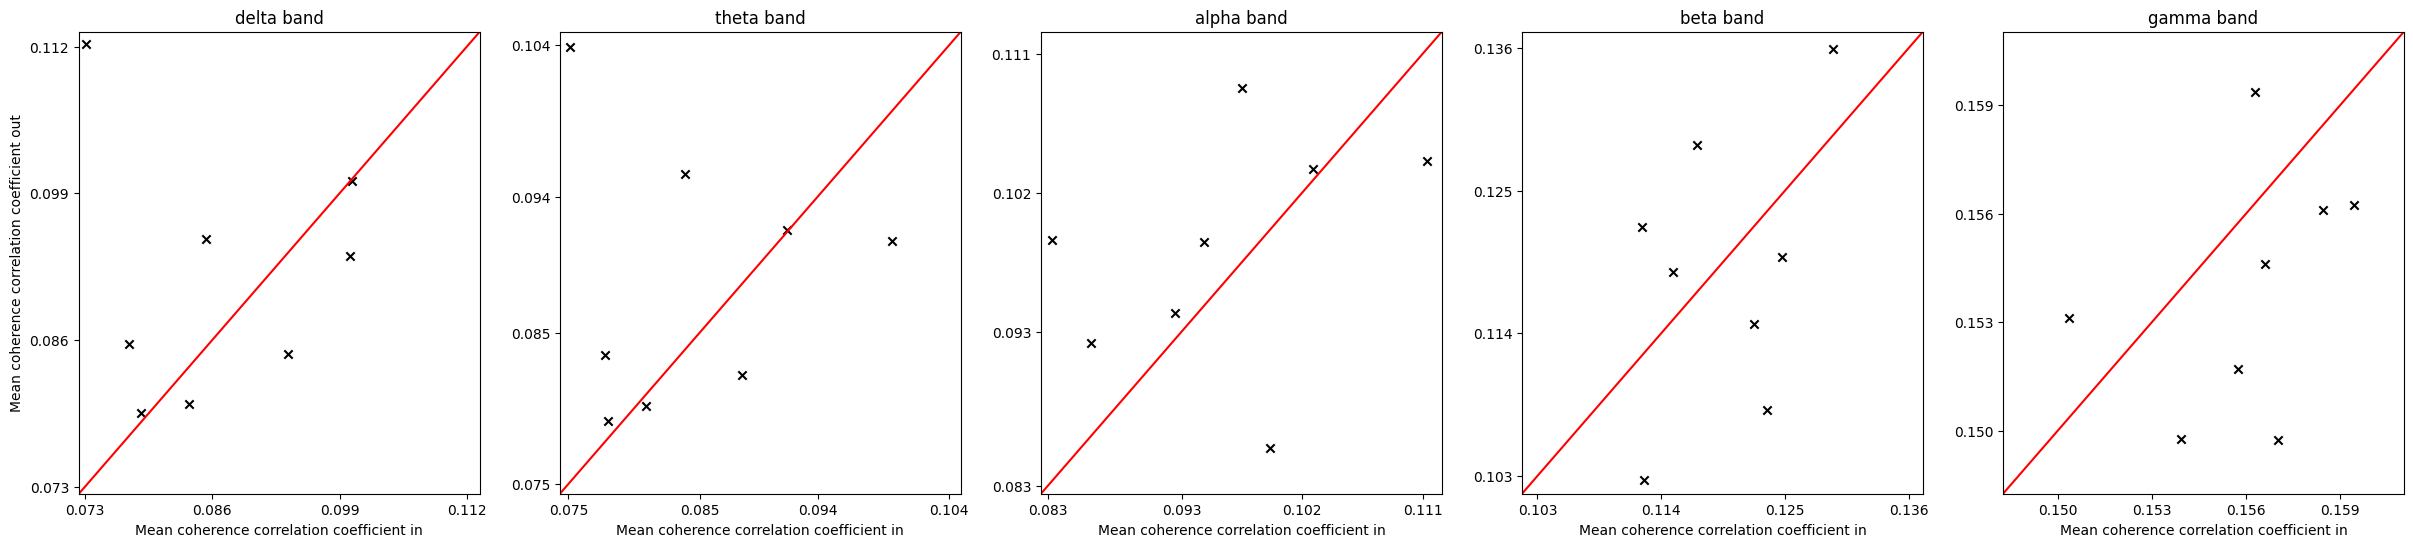

In [2]:
#want a single plot, where for each dataset, mean coherence in and mean coherence out are plotted with error bars
coherence_in = {f'{band}': [] for band in bands}
coherence_out = {f'{band}': [] for band in bands}

for file_number in file_numbers:
    values = []
    errors = []
    for band in bands:
        for condition in ['left_attleft', 'right_attright']:
            values.append(coherence_results[f'dataset_{file_number}'][band][condition] / Norm[f'dataset_{file_number}'][band][condition])
        coherence_in[f'{band}'].append(np.mean(values))

for file_number in file_numbers:
    print(coherence_results[f'dataset_{file_number}']['delta'])


    values = []
    errors = []
    for band in bands:
        for condition in ['left_attright', 'right_attleft']:
            values.append(coherence_results[f'dataset_{file_number}'][band][condition] / Norm[f'dataset_{file_number}'][band][condition])
        coherence_out[f'{band}'].append(np.mean(values))
    
max_values = {f'{band}': [] for band in bands}
min_values = {f'{band}': [] for band in bands}

idx = np.arange(len(file_numbers))
for band in bands:
    values = []
    for f in idx:
        values.append(coherence_in[f'{band}'][f])
        values.append(coherence_out[f'{band}'][f])
    print(values)
    max_values[f'{band}'].append(max(values))
    min_values[f'{band}'].append(min(values))

print(max_values)

fig, axs = plt.subplots(1,5, figsize=(30, 6))
for i, band in enumerate(bands):
    axs[i].scatter(coherence_in[f'{band}'], coherence_out[f'{band}'], marker='x', color='k')
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color='r')
    axs[i].set_xlim(min_values[f'{band}'][0]*(0.99), max_values[f'{band}'][0]*(1.01))
    axs[i].set_ylim(min_values[f'{band}'][0]*(0.99), max_values[f'{band}'][0]*(1.01))
    axs[i].set_xticks(np.round(np.linspace(min_values[f'{band}'][0],max_values[f'{band}'][0], 4), 3))
    axs[i].set_yticks(np.round(np.linspace(min_values[f'{band}'][0],max_values[f'{band}'][0], 4), 3))
    axs[i].set_xlabel('Mean coherence correlation coefficient in')
    axs[0].set_ylabel('Mean coherence correlation coefficient out')
    axs[i].set_title(f'{band} band')
plt.show()
